In [0]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import scipy.stats as st
from scipy.stats import binned_statistic

In [0]:
working_dir = "/content/drive/My Drive/tesi_magistrale/tesi/merged/"
os.chdir(working_dir)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
normalisation_str='counts'

In [6]:
df_files = pd.read_csv("files.dat", index_col=[0])
df_files.head()

,source,status,primary_site
files,,,
TCGA-3X-AAVE-01A-11R-A41I-07,colon-tcga,tumour,colon
TCGA-ZD-A8I3-01A-11R-A41I-07,colon-tcga,tumour,colon
TCGA-ZU-A8S4-01A-11R-A41I-07,colon-tcga,tumour,colon
TCGA-W6-AA0S-01A-11R-A41I-07,colon-tcga,tumour,colon
TCGA-3X-AAVB-01A-31R-A41I-07,colon-tcga,tumour,colon


In [0]:
primaries = df_files['primary_site'].unique()

In [11]:
primaries

array(['colon', 'breast', 'stomach', 'uterus', 'esophagus', 'thyroid',
       'bladder', 'lung', nan], dtype=object)

In [17]:
# GTex
df = pd.read_csv("mainTable.csv", index_col=[1], header=0).drop("Hugo_Symbol",1)
df[df.isna()].any().any()

False

## average tissues

In [0]:
df_tissue = pd.DataFrame(index=df.index)
for tissue in primaries:
    print(tissue)
    df_tissue.insert(0,tissue,df.loc[:,df_files[df_files['tissue']==tissue].index.values].dropna().mean(axis=1))
df_tissue.head()

colon-tcga.txt.gz
colon_sigmoid-tcga.gz
breast-tcga.txt.gz
stomach-gtex.txt.gz
colon-gtex.txt.gz
uterus-tcga.gz
esophagus-tcga.txt.gz
uterus-gtex.gz
breast-gtex.txt.gz
thyroid-gtex.txt.gz
esophagus_gas-gtex.txt.gz
esophagus_mus-gtex.txt.gz
stomach-tcga.gz
bladder-tcga.txt.gz
thyroid-tcga.gz
lung-gtex.gz
colontrasverse-tcga.txt.gz
lung-tcga.gz
esophagus_muc-gtex.txt.gz
bladder-gtex.txt.gz


,bladder-gtex.txt.gz,esophagus_muc-gtex.txt.gz,lung-tcga.gz,colontrasverse-tcga.txt.gz,lung-gtex.gz,thyroid-tcga.gz,bladder-tcga.txt.gz,stomach-tcga.gz,esophagus_mus-gtex.txt.gz,esophagus_gas-gtex.txt.gz,thyroid-gtex.txt.gz,breast-gtex.txt.gz,uterus-gtex.gz,esophagus-tcga.txt.gz,uterus-tcga.gz,colon-gtex.txt.gz,stomach-gtex.txt.gz,breast-tcga.txt.gz,colon_sigmoid-tcga.gz,colon-tcga.txt.gz
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,
CNTRL,168.630909,166.691536,185.558111,190.865333,243.903067,182.500317,170.931077,207.958921,178.781488,195.569333,193.236604,245.340674,210.748415,211.198907,165.181773,128.111268,138.186406,189.755794,186.899540,175.760645
SMC1A,590.217273,546.589288,608.752783,854.084140,509.469425,313.022766,525.743066,928.280632,592.061983,554.691133,482.325126,744.492022,557.376707,779.830546,593.732482,580.667227,568.159844,964.317841,929.830000,521.341935
CACNG6,1.400000,0.720974,29.797276,2.738632,114.789105,0.989252,5.341575,9.504868,2.283388,1.758333,1.006981,9.070674,89.710976,1.510820,69.122553,1.753569,3.920260,31.750000,0.311034,31.534839
ZBBX,0.750000,1.101910,54.905527,0.864421,163.769297,1.980227,1.991243,2.021789,0.632562,1.003600,2.540786,3.285281,66.901341,1.534481,89.485603,1.006283,0.974010,6.695916,0.286092,2.514839
AL645728.1,8.101818,7.570674,7.125805,7.186702,13.836006,12.663492,6.879199,6.321947,9.076198,9.156667,23.120660,14.437640,10.278293,10.036503,9.481560,6.943009,7.646094,10.372546,6.072644,5.377419


## integral

In [0]:
def get_integral_tissue(tissue):
    x = np.sort(df_tissue.loc[:,tissue].fillna(0).values)[::-1]
    norm = np.sum(x)
    return np.cumsum(x/float(norm))

bladder-tcga.txt.gz
bladder-gtex.txt.gz
breast-gtex.txt.gz
breast-tcga.txt.gz
stomach-tcga.gz
stomach-gtex.txt.gz


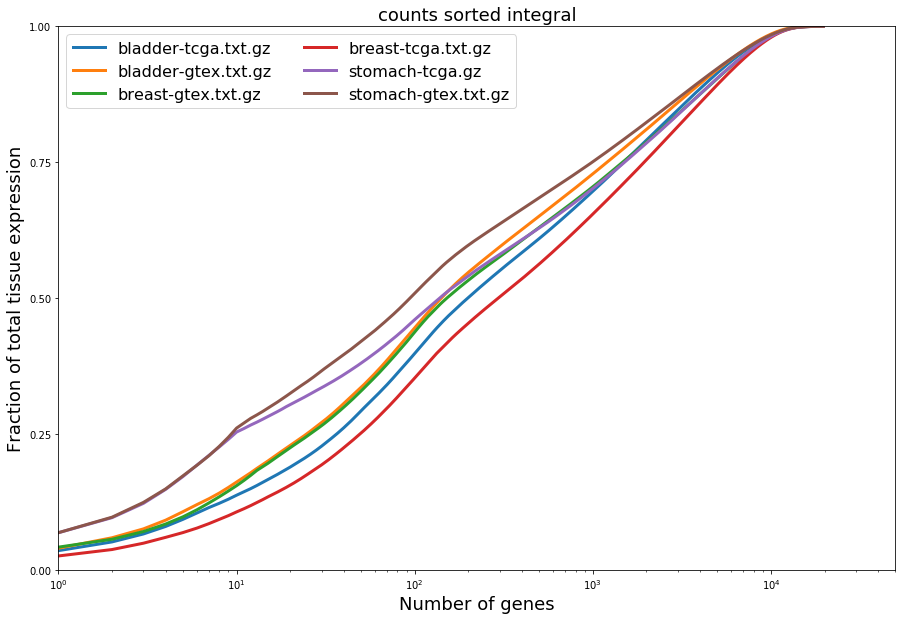

In [0]:
fig=plt.figure(figsize=(15,10))
ax=fig.subplots()
ax.set_title('%s sorted integral'%normalisation_str, fontsize=18)
#for tissue in np.sort(primaries):
for tissue in ['bladder-tcga.txt.gz','bladder-gtex.txt.gz','breast-gtex.txt.gz','breast-tcga.txt.gz','stomach-tcga.gz','stomach-gtex.txt.gz']:
    print(tissue)
    if 'gtex' in tissue:
        c='b'
    else:
        c='r'
    ax.plot(get_integral_tissue(tissue),label=tissue, lw=3)

#blood = df.loc[:,samples[samples['secondary_site']=='Whole Blood'].index.values].values
#ax.plot(np.cumsum(np.sort(blood)[::-1])/np.sum(blood), label='Whole Blood', lw=2)

ax.set_xscale('log')
ax.set_xlabel('Number of genes', fontsize=18)
ax.set_ylabel('Fraction of total tissue expression', fontsize=18)
ax.set_xlim((1,5e4))
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_ylim(0,1)
plt.legend(ncol=2, fontsize=16)
plt.show()
fig.savefig("fraction_of_trascriptome.pdf")

In [0]:
for g in df_tissue['bladder-gtex.txt.gz'].sort_values(ascending=False).index[:10]:
    print(g)

MT-CO1
MT-ATP8
MT-ATP6
MT-CO3
MT-CO2
MT-ND3
MT-ND4
DES
MT-ND2
EEF1A1


## Zipf & Heaps

## Zipf

In [0]:
variable_tissues = ['thyroid-tcga.gz','thyroid-gtex.txt.gz','breast-gtex.txt.gz','breast-tcga.txt.gz']

In [0]:
df_tissue.columns

Index(['bladder-gtex.txt.gz', 'esophagus_muc-gtex.txt.gz', 'lung-tcga.gz',
       'colontrasverse-tcga.txt.gz', 'lung-gtex.gz', 'thyroid-tcga.gz',
       'bladder-tcga.txt.gz', 'stomach-tcga.gz', 'esophagus_mus-gtex.txt.gz',
       'esophagus_gas-gtex.txt.gz', 'thyroid-gtex.txt.gz',
       'breast-gtex.txt.gz', 'uterus-gtex.gz', 'esophagus-tcga.txt.gz',
       'uterus-tcga.gz', 'colon-gtex.txt.gz', 'stomach-gtex.txt.gz',
       'breast-tcga.txt.gz', 'colon_sigmoid-tcga.gz', 'colon-tcga.txt.gz'],
      dtype='object')

In [0]:
def get_zipf_tissue(tissue):
    '''
    return array zipf
    '''
    A = np.sort(df_tissue.loc[:,tissue].dropna().values)[::-1]
    A /= np.sum(A)
    return A

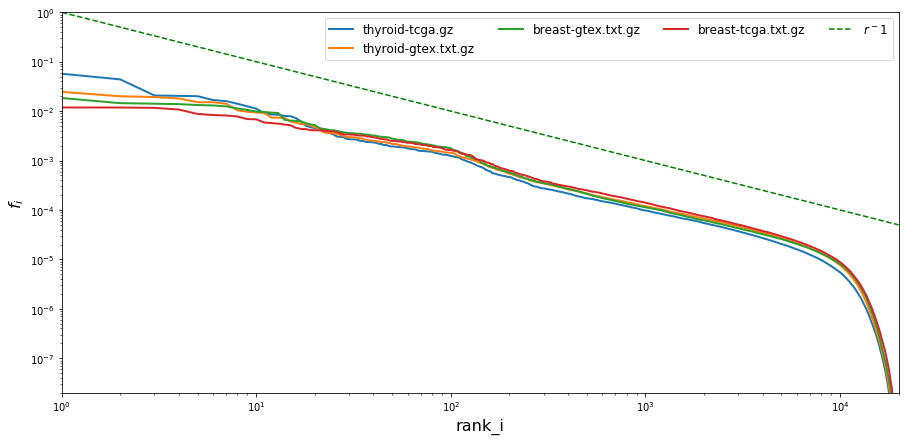

In [0]:
fig = plt.figure(figsize=(15,7))
for tissue in variable_tissues:
    plt.plot(get_zipf_tissue(tissue), lw=2, ls='-', label=tissue)
plt.plot(np.arange(1,2e4), 1./np.arange(1,2e4), 'g--', label='$r^-1$')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('rank_i', fontsize=16)
plt.ylabel('$f_i$', fontsize=16)
plt.xlim(1,2e4)
plt.ylim(2e-8,1e0)
plt.legend(ncol=4, fontsize=12)
plt.show()
fig.savefig("Zipf_tissue.pdf")

## Heaps

In [0]:
def get_heaps_tissue(tissue):
    subdf = df.loc[:,samples[samples['secondary_site'].isin(get_specific_mapping_to(tissue))].index.values]
    M = subdf.apply(lambda x: np.sum(x), axis=0).values
    ndw = subdf.apply(lambda x: len(np.nonzero(x)[0]), axis=0).values
    return M, ndw    

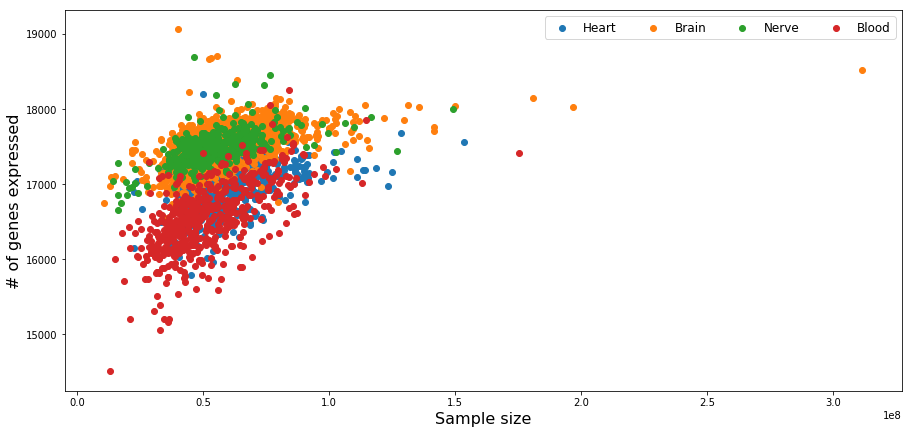

In [0]:
fig = plt.figure(figsize=(15,7))
for tissue in variable_tissues:
    heaps = get_heaps_tissue(tissue)
    plt.scatter(heaps[0], heaps[1],  label=tissue)
plt.xlabel('Sample size', fontsize=16)
plt.ylabel('# of genes expressed', fontsize=16)
plt.legend(ncol=4, fontsize=12)
plt.show()
fig.savefig("Heaps_tissue.pdf")

## global

In [0]:
fig=plt.figure(figsize=(25,8))
ax = fig.subplots(1,3)
colors = (['darksalmon','lawngreen', 'lightskyblue','pink'],['r','g','b','m'])
variable_tissues = ['Heart','Brain','Nerve', 'Blood']
for i,tissue in enumerate(variable_tissues):
    ax[0].plot(get_integral_tissue(tissue), label=tissue, color=colors[0][i])
    ax[1].plot(get_zipf_tissue(tissue), label=tissue,color=colors[0][i])
    heaps = get_heaps_tissue(tissue)
    ax[2].scatter(heaps[0],heaps[1], label=tissue, c=colors[0][i], alpha=0.2)
    bin_means, bin_edges, _ = binned_statistic(heaps[0], heaps[1], bins = np.linspace(0.2e8,1.5e8))
    #bin_means, bin_edges, _ = binned_statistic(heaps[0], heaps[1], bins = np.linspace(8.6e5,9.8e5,8))
    ax[2].scatter((bin_edges[:-1]+bin_edges[1:])/2., bin_means, marker='x', c=colors[1][i], label='binned[%s]'%tissue)
    
ax[1].plot(np.arange(1,1e4), 1./np.arange(1,1e4), 'g--', label='$r^-1$')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[0].legend(fontsize=16)
ax[1].legend(fontsize=16)
ax[2].legend(fontsize=16)
ax[0].set_xlabel('Number of genes', fontsize=16)
ax[0].set_ylabel('Fraction of total tissue expression', fontsize=16)
ax[1].set_xlabel('rank_i', fontsize=16)
ax[1].set_ylabel('$f_i$', fontsize=16)
ax[2].set_xlabel('Sample size', fontsize=16)
ax[2].set_ylabel('# of genes expressed', fontsize=16)
ax[2].set_xlim(0.05e8,1.5e8)
ax[1].set_ylim(1e-6,1)
plt.show()
fig.savefig("zipfheaps_tissue.pdf")

# lenght

In [0]:
q_many = pd.read_csv("genes.txt", index_col=[0], header=[0])
q_many = q_many[q_many['type_of_gene']=='protein-coding']
lenghts = q_many['lenght']

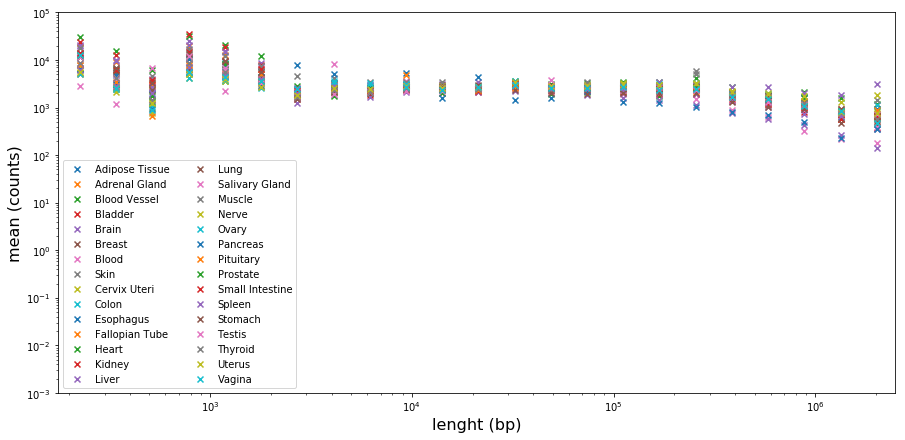

In [0]:
#from scipy.stats import binned_statistic
fig=plt.figure(figsize=(15,7))
bins_for_l = np.logspace(1,8,40)
for tissue in primaries:
    bin_means, bin_edges, _ = binned_statistic(lenghts, df_tissue.loc[:,tissue], statistic='mean', bins=bins_for_l)
    #plt.scatter(lenghts,df_tissue.loc[:,tissue])
    plt.scatter((bin_edges[1:]+bin_edges[:-1])/2,bin_means, marker='x',label=tissue)
    plt.yscale('log')
    plt.xscale('log')
plt.xlabel('lenght (bp)', fontsize=16)
plt.ylabel('mean (counts)', fontsize=16)
plt.xlim((lenghts.min(),lenghts.max()))
plt.ylim((1e-3,1e5))
plt.legend(ncol=2)
plt.show()
fig.savefig("meanLenght_tissue.pdf")

## inter intra

In [0]:
inter_vars = df_tissue.apply(np.var, axis=1).values
inter_means = df_tissue.apply(np.average, axis=1).values

In [0]:
inter_cv2s = [inter_vars[i]/(m*m) if m>0 else 0 for i,m in enumerate(inter_means)]

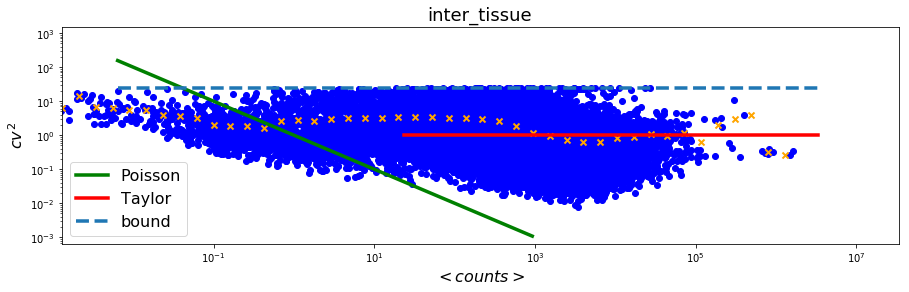

In [0]:
fig=plt.figure(figsize=(15,4))
plt.scatter(inter_means, inter_cv2s, c='b')
plt.plot(x_lin[:30],1./x_lin[:30], 'g-', lw=3.5, label='Poisson')
plt.plot(x_lin[-30:],[1 for _ in x_lin[-30:]], 'r-', lw=3.5, label='Taylor')
plt.plot(x_lin,[len(df_tissue.columns)-1 for _ in x_lin], '--', lw=3.5, label='bound')

bin_means, bin_edges,_=binned_statistic(inter_means, inter_cv2s, statistic='mean', bins=np.logspace(np.log10(np.min(inter_means[inter_means.nonzero()])),np.log10(np.max(inter_means))))

plt.scatter((bin_edges[1:]+bin_edges[:-1])/2, bin_means, marker='x', lw=2, color='orange')

plt.title('inter_tissue',fontsize=18)
plt.xlabel("$<%s>$"%normalisation_str, fontsize=16)
plt.ylabel("$cv^2$", fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xlim(means[means.nonzero()].min()/5,np.power(10,np.log10(means.max())+1))
plt.ylim(variances[variances.nonzero()].min()/10,len(subdf.columns)*10)
plt.legend(fontsize=16)
plt.show()
fig.savefig("cvmean_loglog_inter_tissue.png")

In [0]:
bin_means, bin_edges, binnumber = binned_statistic(inter_means, inter_cv2s, statistic='mean', bins=np.logspace(np.log10(np.min(inter_means[inter_means.nonzero()])),np.log10(np.max(inter_means))))

def get_inter_distance_from_mean(mean, cv2):
    bin_i = 0
    for i,_ in enumerate(bin_edges[:-1]):
        if mean<bin_edges[i+1] and mean > bin_edges[i]:
            bin_i = i
            break
    return(cv2-bin_means[bin_i])

In [0]:
subdf = df.loc[:,samples[samples['primary_site']==tissue].index.values]
intra_means = subdf.apply(np.nanmean, axis=1).values
intra_variance = subdf.apply(np.nanvar, axis=1).values
intra_cv2 = [intra_variance[i]/(np.power(mean,2)) if mean>0 else 0 for i,mean in enumerate(intra_means) ]

bin_means_intra, bin_edges_intra, _ = binned_statistic(intra_means, intra_cv2, statistic='mean', bins=np.logspace(np.log10(np.min(intra_means[intra_means.nonzero()])),np.log10(np.max(intra_means))))

def get_intra_distance_from_mean(mean, cv2):
    bin_i = 0
    for i,_ in enumerate(bin_edges[:-1]):
        if mean<bin_edges_intra[i+1] and mean > bin_edges_intra[i]:
            bin_i = i
            break
    return(cv2-bin_means_intra[bin_i])

In [0]:
inter = []
intra = []
for i,g in enumerate(df_tissue.index.values):
    inter.append(get_inter_distance_from_mean(inter_means[i],inter_cv2s[i]))
    intra.append(get_intra_distance_from_mean(intra_means[i], intra_cv2[i]))
intra=np.array(intra)
inter=np.array(inter)

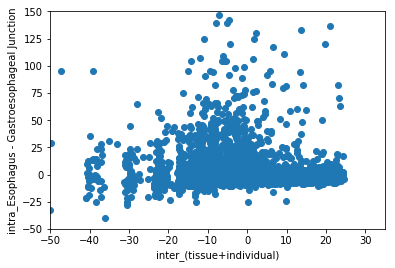

In [0]:
x = np.logspace(np.log10(5e-1),20)
fig = plt.figure()
plt.scatter(inter, intra, label=tissue)
#plt.plot(x,x)
#plt.plot(x,np.sqrt(x))
plt.xlabel('inter_(tissue+individual)')
plt.ylabel('intra_%s'%tissue)
#plt.yscale('log')
#plt.xscale('log')
plt.ylim(-50,150)
plt.xlim(-50,35)
plt.show()
fig.savefig("inter_intra_%s.png"%tissue)

In [0]:
for i, inter_g in enumerate(inter):
    if((np.abs(intra[i])<1) & (inter_g<10 and inter_g>8)):
        print(df.index[i])

ENSG00000109805
ENSG00000126787
ENSG00000188959
ENSG00000183742
ENSG00000179913
ENSG00000131747
ENSG00000141579
ENSG00000047936
ENSG00000181885
ENSG00000134242
ENSG00000137714
ENSG00000066279
ENSG00000206075
ENSG00000158050
ENSG00000156127
ENSG00000030419
ENSG00000123485
ENSG00000166803
ENSG00000111679
ENSG00000120756
ENSG00000171303
ENSG00000137804
ENSG00000010671
ENSG00000141293
ENSG00000237649
ENSG00000105289
ENSG00000197565
ENSG00000175793
ENSG00000158764
ENSG00000085662
ENSG00000169894
ENSG00000079385
ENSG00000114251
ENSG00000174788
ENSG00000102096
ENSG00000196754
ENSG00000248144
ENSG00000122122
ENSG00000237541
ENSG00000070526
